# Ambulance

## Aims:

Compare people who arrived by ambulance to those who did not

Uses full dataset unless stated otherwise (i.e. just restricted by number of admissions - and not by whether arrived within 4 hours of known stroke onset).

<mark>currently exploratory... will need to go through, choose best visualisations, and check I am including all the variables I should be</mark>

## Set up

In [1]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    admission_only_filename = 'reformatted_data_admissions_only.csv'
    data_4h_filename = 'reformatted_data.csv'


paths = Paths()

In [3]:
# Load data
data_full = pd.read_csv(os.path.join(
    paths.data_path, paths.admission_only_filename))
data_4h = pd.read_csv(os.path.join(
    paths.data_path, paths.data_4h_filename))

## Set up

Drop the few patients who are missing data on whether they arrived by ambulance.

In [4]:
data_full = data_full[data_full['arrive_by_ambulance'].notna()]
data_4h = data_4h[data_4h['arrive_by_ambulance'].notna()]

Create columns with month and year, or quarter and year.

In [5]:
# Create datetime with month and year
data_full['month_year_dt'] = pd.to_datetime(
    data_full['year'].astype(str) + '-' +
    data_full['month'].astype(str), format='%Y-%m')

# Convert to period of m (month and year)
data_full['month_year'] = data_full['month_year_dt'].dt.to_period('m')

# Convert to period of q (quarter and year)
data_full['quarter_year'] = data_full['month_year_dt'].dt.to_period('q')

Add stroke severity groups

In [6]:
conditions = [(data_4h['stroke_severity'] == 0),
              (data_4h['stroke_severity'].isin(np.arange(1, 5))),
              (data_4h['stroke_severity'].isin(np.arange(5, 16))),
              (data_4h['stroke_severity'].isin(np.arange(16, 21))),
              (data_4h['stroke_severity'].isin(np.arange(21, 43)))]
nihss_choices = ['A: 0', 'B: 1-4', 'C: 5-15', 'D: 16-20', 'E: 21-42']
data_4h['stroke_severity_groups'] = np.select(conditions, nihss_choices)

## Functions

In [7]:
def proportion_arrivals(group, xlab):
    '''
    Plot the proportion of patients arriving by ambulance in
    the specified groups of patients
    group: string, with categories to find proportions in
    xlab: string, x axis label
    '''
    # Find proportions
    df = data_full.groupby(group)['arrive_by_ambulance'].mean()

    # Set up figure
    fig, ax = plt.subplots(figsize=(5, 3))

    # Create line plot
    df.plot(kind='line', marker='o', markersize=2, ax=ax)
    ax.set_xlabel(xlab)
    ax.set_ylabel('Proportion of patients arriving by ambulance')
    plt.show()


def average_by_arrival(var, ylab):
    '''
    Plots average results for specified variable,
    by whether arrived by ambulance
    var: string, variable of interest
    ylab: string, x axis label
    '''
    # Set up figure
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 3))

    # Transform data
    df = data_full.groupby('arrive_by_ambulance')[var].agg(
        lambda x: list(x))

    # Create violinplot
    ax[0].violinplot(df)
    ax[0].set_xticks(np.arange(1, len(df.index)+1), labels=df.index)
    ax[0].set_xlabel('Arrival by ambulance')
    ax[0].set_ylabel(ylab)

    # Create boxplot
    ax[1].boxplot(df)
    ax[1].set_xlabel('Arrival by ambulance')
    ax[1].set_ylabel(ylab)

    # Show plot
    plt.show()

## Frequency of ambulance arrivals

Observations:
* Overall **79% patients arrived by ambulance**.
* **Proportion of arrivals by ambulance is decreasing** - it was decreasing from 2016 to 2020, then increased with the first COVID-19 lockdown, and decreased over 2021 (duplicates analysis from comparison over time notebook).

,index,n,percent
0,1.0,283190,78.910484
1,0.0,75685,21.089516


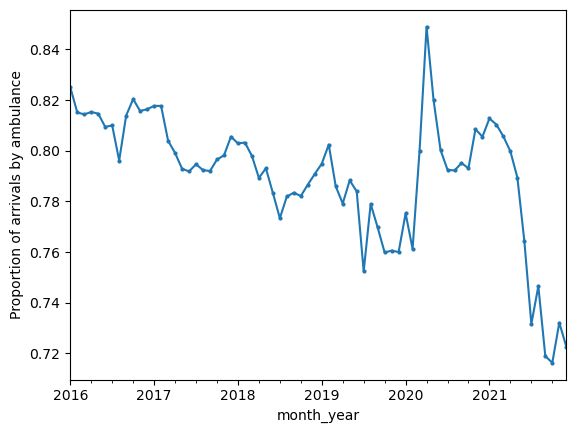

In [8]:
# Find overall frequency
freq = data_full['arrive_by_ambulance'].value_counts().reset_index(name='n')
freq['percent'] = freq['n']/freq['n'].sum()*100
display(freq)

# Plot frequency over time (grouped by month)
df = data_full.groupby('month_year')['arrive_by_ambulance'].mean()
df.plot(kind='line', marker='o', markersize=2)
plt.ylabel('Proportion of arrivals by ambulance')
plt.show()

## Characteristics of patients who arrive by ambulance v.s. not

### Stroke severity

Observations:
* **At greater stroke severities, a higher proportion of patients arrive by ambulance**. From apx. NIHSS 0 to 10 the proportion increases before plateuing around NIHSS 10-15, where the proportion is roughly 95%+.
* Relatedly, patients arriving by ambulance typically had more severe strokes.

<mark>Maybe remove labels from overlaid histograms</mark>

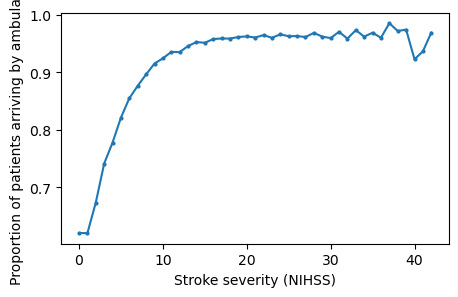

In [9]:
proportion_arrivals('stroke_severity', 'Stroke severity (NIHSS)')

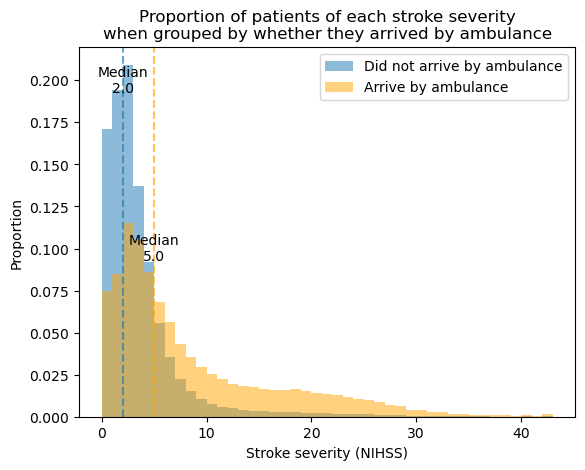

In [10]:
# Seperate ambulance and non-ambulance and find medians
amb = data_full['arrive_by_ambulance'] == 1
amb_df = data_full.loc[amb, 'stroke_severity']
amb_med = amb_df.median()
non_df = data_full.loc[~amb, 'stroke_severity']
non_med = non_df.median()

# Define bins
unique = len(data_full['stroke_severity'].unique())
bins = np.arange(0, unique+1, 1)

# Plot overlaid histograms with median lines
plt.hist(non_df, bins, weights=np.ones(len(non_df))/len(non_df),
         alpha=0.5, label='Did not arrive by ambulance')
plt.axvline(non_med, linestyle='dashed', alpha=0.65)
plt.text(non_med, 0.2, 'Median\n' + str(non_med), ha='center', va='center')

plt.hist(amb_df, bins, weights=np.ones(len(amb_df))/len(amb_df),
         alpha=0.5, color='orange', label='Arrive by ambulance')
plt.axvline(amb_med, color='orange', linestyle='dashed', alpha=0.65)
plt.text(amb_med, 0.1, 'Median\n' + str(amb_med), ha='center', va='center')

# Add legend, labels and titles, then show plot
plt.legend(loc='upper right')
plt.xlabel('Stroke severity (NIHSS)')
plt.ylabel('Proportion')
plt.title('Proportion of patients of each stroke severity\n' +
          'when grouped by whether they arrived by ambulance')
plt.show()

### Age

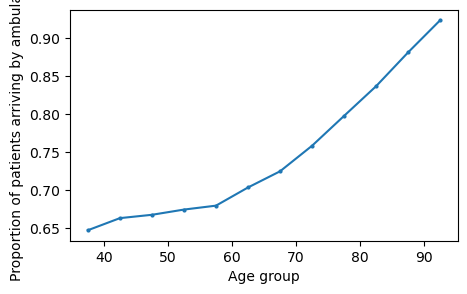

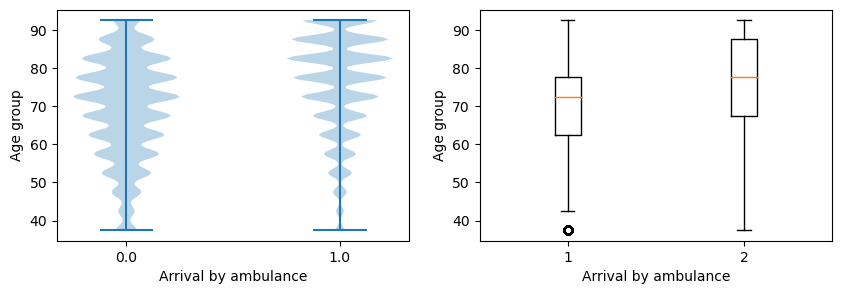

,count,mean,std,min,25%,50%,75%,max
arrive_by_ambulance,,,,,,,,
0.0,75685.0,69.241428,13.371602,37.5,62.5,72.5,77.5,92.5
1.0,283190.0,75.572284,13.029059,37.5,67.5,77.5,87.5,92.5


In [11]:
proportion_arrivals('age', 'Age group')
average_by_arrival('age', 'Age group')
data_full.groupby('arrive_by_ambulance')['age'].describe()

### Discharge disability

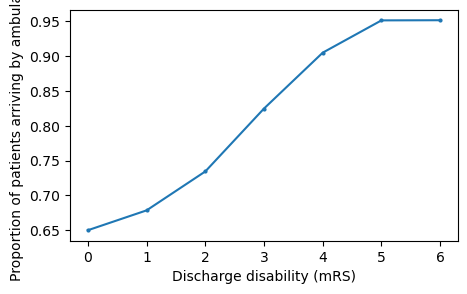

,count,mean,std,min,25%,50%,75%,max
arrive_by_ambulance,,,,,,,,
0.0,75322.0,1.649823,1.425685,0.0,1.0,1.0,2.0,6.0
1.0,281024.0,2.917954,1.945565,0.0,1.0,3.0,4.0,6.0


In [12]:
proportion_arrivals('discharge_disability', 'Discharge disability (mRS)')
data_full.groupby('arrive_by_ambulance')['discharge_disability'].describe()

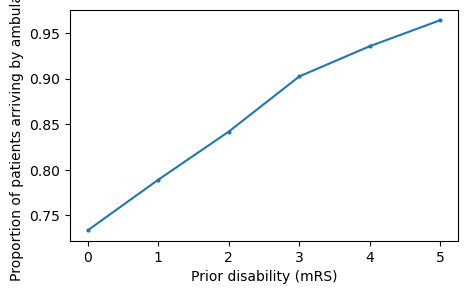

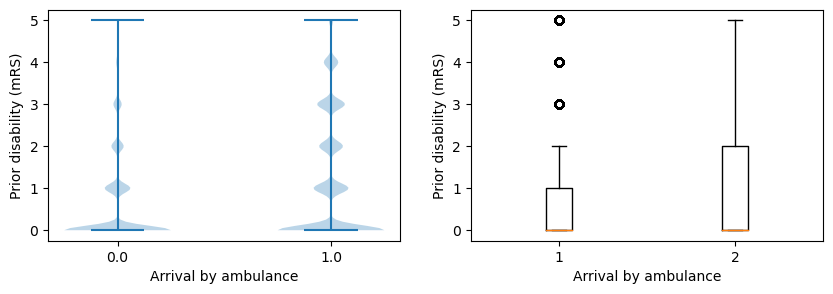

,count,mean,std,min,25%,50%,75%,max
arrive_by_ambulance,,,,,,,,
0.0,75685.0,0.567986,0.995295,0.0,0.0,0.0,1.0,5.0
1.0,283190.0,1.157152,1.430806,0.0,0.0,0.0,2.0,5.0


In [13]:
proportion_arrivals('prior_disability', 'Prior disability (mRS)')
average_by_arrival('prior_disability', 'Prior disability (mRS)')
data_full.groupby('arrive_by_ambulance')['prior_disability'].describe()

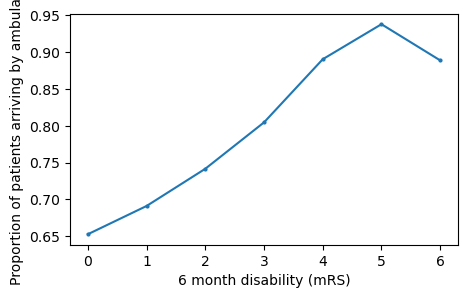

,count,mean,std,min,25%,50%,75%,max
arrive_by_ambulance,,,,,,,,
0.0,26984.0,1.572932,1.473989,0.0,1.0,1.0,2.0,6.0
1.0,82337.0,2.374898,1.861619,0.0,1.0,2.0,3.0,6.0


In [14]:
proportion_arrivals('disability_6_month', '6 month disability (mRS)')
data_full.groupby('arrive_by_ambulance')['disability_6_month'].describe()

look at proportion throm in 4h...

create overlapping histograms of process time distributions...

### Thrombolysis

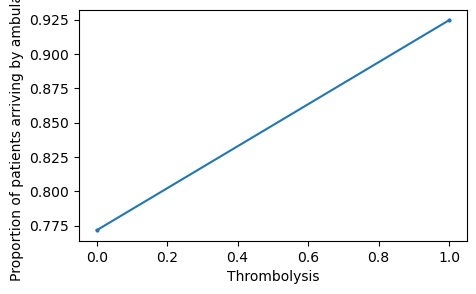

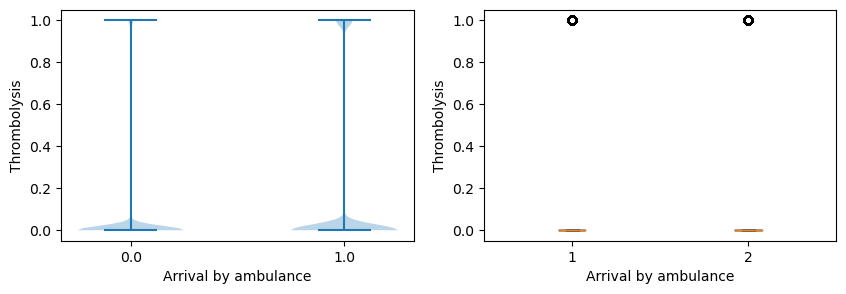

,count,mean,std,min,25%,50%,75%,max
arrive_by_ambulance,,,,,,,,
0.0,75685.0,0.041025,0.198350,0.0,0.0,0.0,0.0,1.0
1.0,283190.0,0.134306,0.340981,0.0,0.0,0.0,0.0,1.0


In [15]:
proportion_arrivals('thrombolysis', 'Thrombolysis')
average_by_arrival('thrombolysis', 'Thrombolysis')
data_full.groupby('arrive_by_ambulance')['thrombolysis'].describe()

In [16]:
data_full['4hours'] = np.where(data_full['onset_to_arrival_time'] <= 240, 1, 0)
data_full.groupby('arrive_by_ambulance')['4hours'].mean()

arrive_by_ambulance
0.0    0.17405
1.0    0.43730
Name: 4hours, dtype: float64

In [17]:
data_4h['arrive_by_ambulance'].value_counts(normalize=True)

1.0    0.903855
0.0    0.096145
Name: arrive_by_ambulance, dtype: float64

In [18]:
data_4h.groupby('arrive_by_ambulance')['thrombolysis'].mean()

arrive_by_ambulance
0.0    0.229560
1.0    0.299009
Name: thrombolysis, dtype: float64

In [19]:
data_4h.groupby('arrive_by_ambulance')['arrival_to_scan_time'].describe()

,count,mean,std,min,25%,50%,75%,max
arrive_by_ambulance,,,,,,,,
0.0,13173.0,149.006073,1311.917713,1.0,27.0,51.0,109.0,87883.0
1.0,123839.0,93.860625,1540.675959,1.0,15.0,26.0,50.0,440117.0


In [20]:
data_4h.groupby('arrive_by_ambulance')['scan_to_thrombolysis_time'].describe()

,count,mean,std,min,25%,50%,75%,max
arrive_by_ambulance,,,,,,,,
0.0,3024.0,41.118056,30.193328,0.0,22.0,34.0,51.0,318.0
1.0,37029.0,36.795998,28.463958,0.0,19.0,30.0,47.0,656.0


In [21]:
data_4h.groupby('arrive_by_ambulance')['stroke_severity'].describe()

,count,mean,std,min,25%,50%,75%,max
arrive_by_ambulance,,,,,,,,
0.0,13173.0,5.096257,6.087541,0.0,1.0,3.0,6.0,42.0
1.0,123839.0,9.326149,8.361657,0.0,3.0,6.0,14.0,42.0


In [22]:
data_4h.groupby(['arrive_by_ambulance',
                 'stroke_severity_groups'])['arrival_to_scan_time'].describe()

count        mean          std  \
arrive_by_ambulance stroke_severity_groups                                     
0.0                 A: 0                     1591.0  245.048397  1053.059373   
                    B: 1-4                   6976.0  161.355075  1618.401290   
                    C: 5-15                  3546.0  105.600677   824.333522   
                    D: 16-20                  494.0   54.742915   329.950584   
                    E: 21-42                  566.0   81.040636   509.034909   
1.0                 A: 0                     7063.0  233.029024   810.913557   
                    B: 1-4                  40882.0  107.378651   747.218911   
                    C: 5-15                 47618.0   84.431034  2301.285863   
                    D: 16-20                12467.0   55.868934   827.998558   
                    E: 21-42                15809.0   55.089696   593.621662   

                                            min   25%    50%    75%       max  
arrive_by_ambulance stroke_severity_groups                                     
0.0                 A: 0                    1.0  48.0  103.0  197.0   35897.0  
                    B: 1-4                  1.0  34.0   61.0  124.0   87883.0  
                    C: 5-15                 1.0  20.0   35.0   63.0   42052.0  
                    D: 16-20                1.0  11.0   23.0   39.0    7076.0  
                    E: 21-42                1.0  13.0   23.0   42.0    8175.0  
1.0                 A: 0                    1.0  28.0   69.0  173.0   21732.0  
                    B: 1-4                  1.0  17.0   32.0   71.0   44941.0  
                    C: 5-15                 1.0  13.0   23.0   40.0  440117.0  
                    D: 16-20                1.0  12.0   21.0   35.0   44698.0  
                    E: 21-42                1.0  13.0   23.0   40.0   43220.0

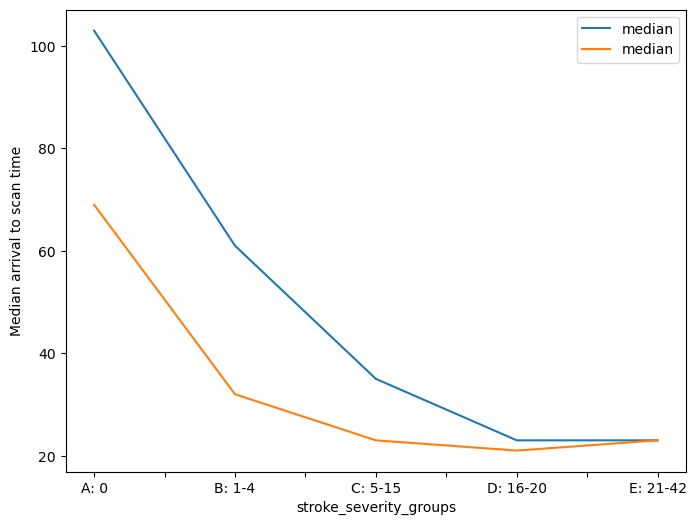

In [23]:
df = (data_4h
      .groupby(['arrive_by_ambulance',
                'stroke_severity_groups'])['arrival_to_scan_time']
      .median()
      .reset_index(name='median'))
fig, ax = plt.subplots(figsize=(8, 6))
df.groupby('arrive_by_ambulance').plot(
    x='stroke_severity_groups', y='median', ax=ax)
ax.set_ylabel('Median arrival to scan time')
plt.show()

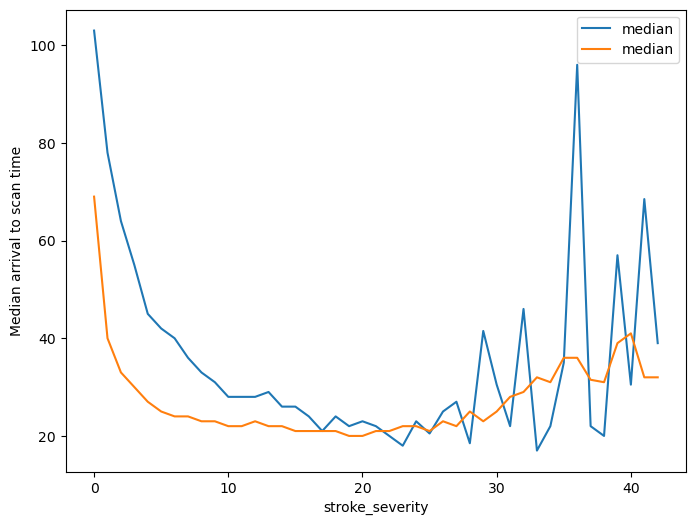

In [24]:
df = (data_4h
      .groupby(['arrive_by_ambulance',
                'stroke_severity'])['arrival_to_scan_time']
      .median()
      .reset_index(name='median'))
fig, ax = plt.subplots(figsize=(8, 6))
df.groupby('arrive_by_ambulance').plot(
    x='stroke_severity', y='median', ax=ax)
ax.set_ylabel('Median arrival to scan time')
plt.show()

### Times

<mark> to do </mark>

### Other

Patients who arrived by ambulance typically had:
* More severe strokes (NIHSS)
* Higher discharge disability (Rankin)
* Shorter arrival to scan time
* Similar scan to thrombolysis time and onset to arrival

In [25]:
(data_full
 .groupby('arrive_by_ambulance')[['onset_to_arrival_time',
                                  'prior_disability',
                                  'discharge_disability',
                                  'stroke_severity',
                                  'arrival_to_scan_time',
                                  'scan_to_thrombolysis_time']]
 .describe()
 .unstack()
 .reset_index(name='value')
 .rename(columns={'level_0': 'variable', 'level_1': 'analysis'})
 .pivot(index=['variable', 'arrive_by_ambulance'],
        columns='analysis', values='value'))

analysis                                         25%    50%     75%     count  \
variable                  arrive_by_ambulance                                   
arrival_to_scan_time      0.0                   46.0  103.0   197.0   75685.0   
                          1.0                   19.0   42.0   110.0  283190.0   
discharge_disability      0.0                    1.0    1.0     2.0   75322.0   
                          1.0                    1.0    3.0     4.0  281024.0   
onset_to_arrival_time     0.0                  162.0  577.0  1582.0   40740.0   
                          1.0                   91.0  164.0   427.0  199754.0   
prior_disability          0.0                    0.0    0.0     1.0   75685.0   
                          1.0                    0.0    0.0     2.0  283190.0   
scan_to_thrombolysis_time 0.0                   22.0   34.0    52.0    3105.0   
                          1.0                   19.0   30.0    47.0   38034.0   
stroke_severity           0.0                    1.0    2.0     4.0   75685.0   
                          1.0                    2.0    5.0    12.0  283190.0   

analysis                                              max         mean  min  \
variable                  arrive_by_ambulance                                 
arrival_to_scan_time      0.0                     89307.0   246.715452  1.0   
                          1.0                    526050.0   181.807730  1.0   
discharge_disability      0.0                         6.0     1.649823  0.0   
                          1.0                         6.0     2.917954  0.0   
onset_to_arrival_time     0.0                   8467360.0  2449.159008  1.0   
                          1.0                  62064145.0  1514.614941  1.0   
prior_disability          0.0                         5.0     0.567986  0.0   
                          1.0                         5.0     1.157152  0.0   
scan_to_thrombolysis_time 0.0                       426.0    41.290821  0.0   
                          1.0                       656.0    36.845954  0.0   
stroke_severity           0.0                        42.0     3.221405  0.0   
                          1.0                        42.0     8.087242  0.0   

analysis                                                 std  
variable                  arrive_by_ambulance                 
arrival_to_scan_time      0.0                    1251.524747  
                          1.0                    2037.985255  
discharge_disability      0.0                       1.425685  
                          1.0                       1.945565  
onset_to_arrival_time     0.0                   60017.801447  
                          1.0                  172824.742837  
prior_disability          0.0                       0.995295  
                          1.0                       1.430806  
scan_to_thrombolysis_time 0.0                      31.338670  
                          1.0                      28.812603  
stroke_severity           0.0                       4.220664  
                          1.0                       8.062619

Patients who arrived by ambulance...
* Lower proportion had infarction
* Higher proportion thrombolysed

In [27]:
# Convert from 0/1 to False/True
amb_compare_cols = ['thrombolysis', 'infarction']
amb_compare = data_full[amb_compare_cols] == 1

# Add whether arrived by ambulance
amb_compare['arrive_by_ambulance'] = data_full['arrive_by_ambulance']

# Groupby arrive by ambulance and find proportion == 1
# (e.g. proportion thrombolysed)
(amb_compare
 .groupby('arrive_by_ambulance')
 .agg({i: 'mean' for i in amb_compare_cols}))*100

,thrombolysis,infarction
arrive_by_ambulance,,
0.0,4.102530,91.718306
1.0,13.430559,86.735407


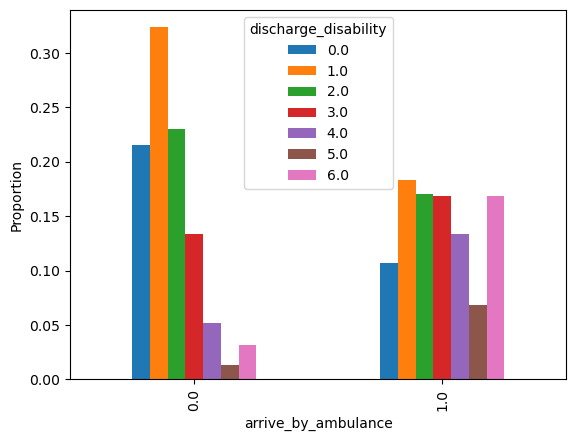

In [28]:
# Create grouped bar plot based on proportions
(data_full
 .groupby('arrive_by_ambulance')['discharge_disability']
 .value_counts(normalize=True)
 .unstack('discharge_disability')
 .plot.bar())
plt.ylabel('Proportion')
plt.show()